In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021


In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from Modelling import modelling
import matplotlib.pyplot as plt
from DataPrep.ImportData import importer
from DataPrep.LagCreation import lags
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pyforest

In [5]:
df = importer().Import()

In [6]:
df=df[df["Label"]==6.0]
df=df.sort_values("Start Date")

In [7]:
df

,Start Date,Label,Charging Time (mins),Energy (kWh),Total Duration (mins),Port Number,CenterLon,CenterLat,Level 1,Level 2,# Professional & Other Places,# Food,# Shop & Service,# Travel & Transport,# Outdoors & Recreation,# Arts & Entertainment,# Nightlife Spot,# Residence,# College & University,# Event,Cluster_0.0,Cluster_1.0,Cluster_2.0,Cluster_3.0,Cluster_4.0,Cluster_5.0,Cluster_6.0,Cluster_7.0,Month_Day_1,Month_Day_2,Month_Day_3,Month_Day_4,Month_Day_5,Month_Day_6,Month_Day_7,Month_Day_8,Month_Day_9,Month_Day_10,Month_Day_11,Month_Day_12,Month_Day_13,Month_Day_14,Month_Day_15,Month_Day_16,Month_Day_17,Month_Day_18,Month_Day_19,Month_Day_20,Month_Day_21,Month_Day_22,Month_Day_23,Month_Day_24,Month_Day_25,Month_Day_26,Month_Day_27,Month_Day_28,Month_Day_29,Month_Day_30,Month_Day_31,Week_Day_0,Week_Day_1,Week_Day_2,Week_Day_3,Week_Day_4,Week_Day_5,Week_Day_6,Year_Month_1,Year_Month_2,Year_Month_3,Year_Month_4,Year_Month_5,Year_Month_6,Year_Month_7,Year_Month_8,Year_Month_9,Year_Month_10,Year_Month_11,Year_Month_12,is_holiday,is_weekend
14403,2016-01-14,6.0,402.585426,1.502495,488.727829,20.0,-122.146,37.427,0,10,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14404,2016-01-15,6.0,796.514574,2.082767,1117.105504,26.0,-122.146,37.427,0,13,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14405,2016-01-16,6.0,290.650000,0.724027,315.200000,18.0,-122.146,37.427,0,9,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
14406,2016-01-17,6.0,674.550000,2.229679,786.533333,24.0,-122.146,37.427,0,12,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
14407,2016-01-18,6.0,973.116667,2.061843,1025.866667,32.0,-122.146,37.427,0,16,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15840,2019-12-27,6.0,1362.816667,2.046395,1536.633333,43.0,-122.146,37.426,0,29,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15841,2019-12-28,6.0,779.333333,2.465923,833.600000,26.0,-122.146,37.426,0,16,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
15842,2019-12-29,6.0,1301.100000,2.140442,1321.416667,52.0,-122.146,37.426,0,35,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
15843,2019-12-30,6.0,1795.066667,2.370722,2161.650000,54.0,-122.146,37.426,0,35,259,208,269,68,85,60,48.0,24.0,13.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [44]:
#X = df[['Energy (kWh)_lag1', 'Energy (kWh)_lag2',
#       'Energy (kWh)_lag3', 'Energy (kWh)_lag4', 'Energy (kWh)_lag5']]
#X = df["Charging Time (mins)"]
y = df[["Energy (kWh)","Start Date"]].set_index("Start Date",drop=False)
y= y.resample("d").min()
X = lags().buildLaggedFeatures(y["Energy (kWh)"], ["Energy (kWh)"],5, dropna=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [45]:
X_train=X_train.drop(columns="lag_0")
X_test=X_test.drop(columns="lag_0")

In [280]:
#y_test['Energy (kWh)'] = np.log(y_test['Energy (kWh)'])
#y_test['Energy (kWh)'] = y_test['Energy (kWh)'].diff().dropna()


#y_train['Energy (kWh)'] = np.log(y_train['Energy (kWh)'])
#y_train['Energy (kWh)'] = y_train['Energy (kWh)'].diff().dropna()

#y_train = y_train.set_index("Start Date",drop=False)
#y_test = y_test.set_index("Start Date",drop=False)




#y_test.index = y_test.index.to_period('D')
#y_train.index = y_train.index.to_period('D')

<IPython.core.display.Javascript object>

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
y_train = y_train.set_index("Start Date",drop=False)
y_test = y_test.set_index("Start Date",drop=False)

In [46]:
y_train["Energy (kWh)"]

Start Date
2016-01-14    1.502495
2016-01-15    2.082767
2016-01-16    0.724027
2016-01-17    2.229679
2016-01-18    2.061843
                ...   
2018-12-30    2.312349
2018-12-31    2.272556
2019-01-01    3.102005
2019-01-02    2.188052
2019-01-03    2.726217
Freq: D, Name: Energy (kWh), Length: 1086, dtype: float64

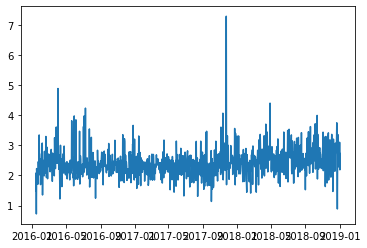

In [47]:
plt.plot(y_train["Energy (kWh)"])
plt.show()

In [66]:
#y_test.index=y_test["Start Date"]
#y_test = y_test.drop(columns="Start Date")
#y_train.index=y_train["Start Date"]
#y_train = y_train.drop(columns="Start Date")


In [264]:
#y_test['Energy (kWh)'] = np.log(y_test['Energy (kWh)'])
#y_test['Energy (kWh)'] = y_test['Energy (kWh)'].diff().dropna()
#y_test.index=y_test["Start Date"]
#y_test.index = y_test.index.to_period('D')
#y_test = y_test.drop(columns="Start Date")

#y_train['Energy (kWh)'] = np.log(y_train['Energy (kWh)'])
#y_train['Energy (kWh)'] = y_train['Energy (kWh)'].diff().dropna()
#y_train.index=y_train["Start Date"]
#y_train.index = y_train.index.to_period('D')
#y_train = y_train.drop(columns="Start Date")

<IPython.core.display.Javascript object>

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [221]:
#y_train['Energy (kWh)'] = np.log(y_train['Energy (kWh)'])
#y_train['Energy (kWh)'] = y_train['Energy (kWh)'].diff()
#y_train = y_train.dropna()
#y_train

<IPython.core.display.Javascript object>

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Energy (kWh),Start Date
6,0.122731,2011-08-04
7,-0.187535,2011-08-05
8,0.230203,2011-08-06
9,0.119161,2011-08-07
10,-0.608959,2011-08-08
...,...,...
2303,0.127576,2017-11-19
2304,0.135252,2017-11-20
2305,0.015620,2017-11-21
2306,0.072955,2017-11-22


In [9]:
y_train

,Energy (kWh),Start Date
Start Date,,
2016-01-14,1.502495,2016-01-14
2016-01-15,2.082767,2016-01-15
2016-01-16,0.724027,2016-01-16
2016-01-17,2.229679,2016-01-17
2016-01-18,2.061843,2016-01-18
...,...,...
2018-12-27,2.947812,2018-12-27
2018-12-28,2.720667,2018-12-28
2018-12-29,2.652957,2018-12-29


In [48]:
result = adfuller(y_train["Energy (kWh)"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.173110
p-value: 0.000731


In [14]:
#y_test = y_test.diff().dropna()
y_train = y_train.diff().dropna()

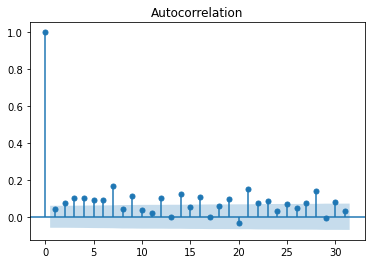

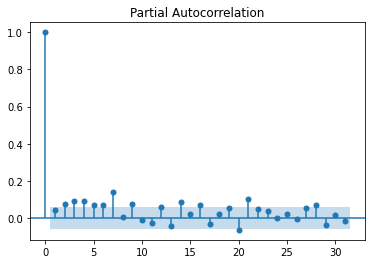

In [18]:
plot_acf(y_train["Energy (kWh)"].dropna())
plt.show()
plot_pacf(y_train["Energy (kWh)"].dropna())
plt.show()

In [70]:
y_test  = y_test.fillna(0)

In [49]:
y_train.freq= "D"

In [35]:
y_train = y_train.resample("d").min()

In [50]:
#from scipy.interpolate import interp1d
y_train[y_train["Energy (kWh)"].isna()]
#y_train = y_train[y_train["Start Date"]!="2018-08-29"]
#y_train = y_train[y_train["Start Date"]!="2018-09-23"]
#y_train

y_train["Energy (kWh)"][y_train["Energy (kWh)"].isna()] = 0
#y2 = interp1d(range(len(y_train["Start Date"])),y_train["Energy (kWh)"])
#y2(len(y_test["Energy (kWh)"].isna()))

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\pandas\core\series.py:963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [360]:
#model1 = ARIMA(y_train["Energy (kWh)"][y_train["Start Date"].dt.year>2012] ,order=(1,0,8), freq="D")

In [53]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5
Start Date,,,,,
2016-01-14,NaN,NaN,NaN,NaN,NaN
2016-01-15,1.502495,NaN,NaN,NaN,NaN
2016-01-16,2.082767,1.502495,NaN,NaN,NaN
2016-01-17,0.724027,2.082767,1.502495,NaN,NaN
2016-01-18,2.229679,0.724027,2.082767,1.502495,NaN
...,...,...,...,...,...
2018-12-30,2.652957,2.720667,2.947812,3.356438,2.748857
2018-12-31,2.312349,2.652957,2.720667,2.947812,3.356438
2019-01-01,2.272556,2.312349,2.652957,2.720667,2.947812


In [297]:
sam = SARIMAX((y_train["Energy (kWh)"]),exog=X_train.fillna(0), order=(5,0,5), seasonal_order=(5,0,4,7), trend="n", freq="D")

ValueError: Models with time-varying regression coefficients must integrate the coefficients as part of the state vector, so that `mle_regression` must be set to False.

In [291]:
sam_fit = sam.fit(method="lbfgs")

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021\env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [292]:
sam_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                 Energy (kWh)   No. Observations:                 1086
Model:             SARIMAX(5, 0, 5)x(5, 0, [1, 2, 3, 4], 7)   Log Likelihood                -718.202
Date:                                      Wed, 24 Mar 2021   AIC                           1486.403
Time:                                              16:56:10   BIC                           1611.160
Sample:                                          01-14-2016   HQIC                          1533.629
                                               - 01-03-2019                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          0.7500      0.147      5.089      0.000       0.461       1.039
lag_2          0.1659      0.153      1.087      0.277      -0.133       0.465
lag_3         -0.0227      0.104     -0.218      0.827      -0.226       0.181
lag_4         -0.0016      0.074     -0.022      0.982      -0.147       0.144
lag_5          0.1084      0.063      1.728      0.084      -0.015       0.231
ar.L1         -0.3326      0.204     -1.626      0.104      -0.733       0.068
ar.L2         -0.4469      0.214     -2.088      0.037      -0.867      -0.027
ar.L3          0.1571      0.178      0.884      0.377      -0.191       0.506
ar.L4         -0.4105      0.176     -2.334      0.020      -0.755      -0.066
ar.L5          0.2732      0.096      2.834      0.005       0.084       0.462
ma.L1         -0.3384      0.199     -1.703      0.089      -0.728       0.051
ma.L2          0.0668      0.146      0.457      0.648      -0.220       0.353
ma.L3         -0.4219      0.117     -3.618      0.000      -0.650      -0.193
ma.L4          0.4878      0.175      2.785      0.005       0.145       0.831
ma.L5         -0.5941      0.125     -4.742      0.000      -0.840      -0.349
ar.S.L7        0.1811      0.820      0.221      0.825      -1.425       1.788
ar.S.L14       0.0131      0.621      0.021      0.983      -1.204       1.230
ar.S.L21       0.2701      0.686      0.394      0.694      -1.074       1.615
ar.S.L28       0.2800      0.816      0.343      0.732      -1.319       1.879
ar.S.L35       0.0173      0.082      0.211      0.833      -0.143       0.177
ma.S.L7       -0.0476      0.816     -0.058      0.953      -1.646       1.551
ma.S.L14       0.0362      0.614      0.059      0.953      -1.167       1.239
ma.S.L21      -0.2179      0.635     -0.343      0.731      -1.462       1.026
ma.S.L28      -0.2837      0.737     -0.385      0.700      -1.728       1.161
sigma2         0.2177      0.006     38.525      0.000       0.207       0.229
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):              6555.53
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             1.14
Prob(H) (two-sided):                  0.70   Kurtosis:                        14.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

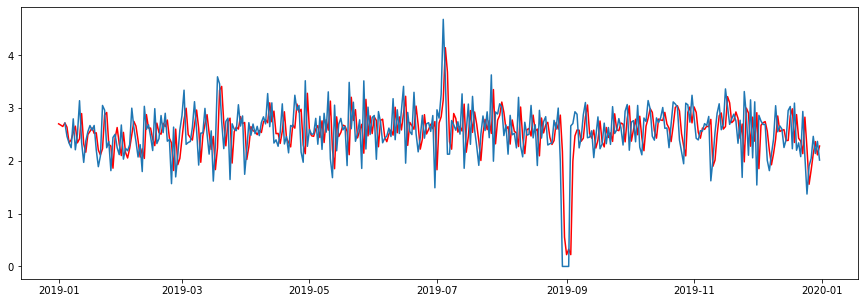

In [293]:
plt.rcParams["figure.figsize"] = (15,5)
plt.plot(sam_fit.predict(start=pd.to_datetime("2019-01-01"),end=pd.to_datetime("2019-12-31"), dynamic=False,typ="levels", exog=X_test.fillna(0)),c="r")
#plt.plot(y_test["Energy (kWh)"])
plt.plot(y_test["Energy (kWh)"])
#plt.figure(figsize=(15, 3))
plt.show()

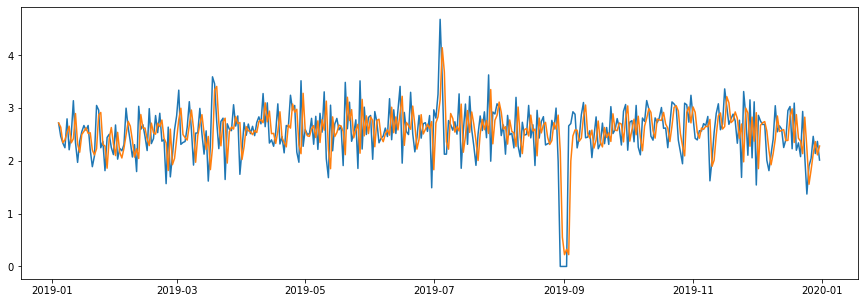

In [294]:
n=362
y_pred = sam_fit.forecast(steps = n, exog=X_test.fillna(0))
plt.plot(y_test["Energy (kWh)"])
plt.plot(y_pred)
plt.show()

In [296]:
print("r^2:", r2_score(y_test["Energy (kWh)"],y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test["Energy (kWh)"],y_pred))) 

r^2: -0.17435456397476035


<IPython.core.display.Javascript object>

RMSE 0.5373288360181832


In [231]:
y_pred[1:]
y_test

,Energy (kWh),Start Date
Start Date,,
2019-01-04,2.716250,2019-01-04 00:00:00
2019-01-05,2.466514,2019-01-05 00:00:00
2019-01-06,2.338961,2019-01-06 00:00:00
2019-01-07,2.250308,2019-01-07 00:00:00
2019-01-08,2.797843,2019-01-08 00:00:00
...,...,...
2019-12-27,2.046395,2019-12-27 00:00:00
2019-12-28,2.465923,2019-12-28 00:00:00
2019-12-29,2.140442,2019-12-29 00:00:00


In [92]:
model = auto_arima(y_train["Energy (kWh)"], exog=X_train,start_p=2,start_q=2,trace=True, suppress_warnings=True, seasonal=True, m=7,trend="c",scoring="mae")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.69 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2174.195, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1830.470, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1414.157, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2174.195, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1426.950, Time=0.39 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=1414.290, Time=2.64 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1412.736, Time=0.73 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=1412.094, Time=2.27 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=3.73 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=2153.207, Time=0.37 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=1414.019, Time=2.97 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=1414.020, Time=3.84 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1831.0

In [363]:
model_fit = model1.fit(method="innovations_mle")
# solver="bfgs"
#method="innovations_mle"
#model_fit = model.fit(y_train)

In [364]:
model_fit.mle_retvals

AttributeError: 'ARIMAResults' object has no attribute 'mle_retvals'

In [365]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Energy (kWh)   No. Observations:                 1788
Model:                 ARIMA(1, 0, 8)   Log Likelihood                 547.525
Date:                Thu, 18 Mar 2021   AIC                          -1073.049
Time:                        23:34:25   BIC                          -1012.672
Sample:                    01-01-2013   HQIC                         -1050.754
                         - 11-23-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.744      0.457      -0.000       0.001
ar.L1          0.4463      0.229      1.947      0.052      -0.003       0.896
ma.L1         -1.3908      0.228     -6.102      0.000      -1.838      -0.944
ma.L2          0.4100      0.218      1.883      0.060      -0.017       0.837
ma.L3          0.0096      0.042      0.227      0.820      -0.073       0.093
ma.L4         -0.0110      0.041     -0.267      0.790      -0.092       0.070
ma.L5         -0.0432      0.041     -1.062      0.288      -0.123       0.037
ma.L6          0.0755      0.043      1.737      0.082      -0.010       0.161
ma.L7          0.0527      0.043      1.218      0.223      -0.032       0.137
ma.L8         -0.0769      0.022     -3.453      0.001      -0.120      -0.033
sigma2         0.0317      0.001     39.174      0.000       0.030       0.033
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               222.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

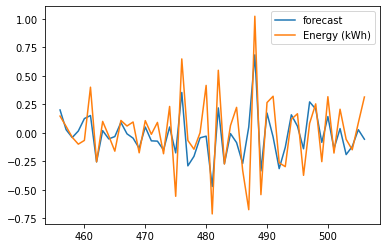

In [240]:
model_fit.plot_predict(start=450,end=500,dynamic=False);

In [186]:
model_fit.resid[1:50]

Start Date
2011-08-05   -0.212560
2011-08-06    0.257541
2011-08-07    0.451112
2011-08-08   -0.666540
2011-08-09   -0.539129
2011-08-10   -0.274690
2011-08-11   -0.360386
2011-08-12   -0.487774
2011-08-13   -0.116456
2011-08-14    0.015908
2011-08-15   -0.121723
2011-08-16    0.018642
2011-08-17    0.254776
2011-08-18   -0.195000
2011-08-19    0.047391
2011-08-20   -0.493770
2011-08-21    0.191207
2011-08-22   -0.152813
2011-08-23    0.305532
2011-08-24   -0.030957
2011-08-25   -0.071338
2011-08-26   -0.314190
2011-08-27    0.405798
2011-08-28    0.063372
2011-08-29   -0.185554
2011-08-30    0.432549
2011-08-31   -0.029924
2011-09-01    0.166059
2011-09-02    0.421753
2011-09-03    0.131118
2011-09-04   -0.065864
2011-09-05    0.616368
2011-09-06   -0.560386
2011-09-07   -0.192589
2011-09-08    0.121692
2011-09-10   -0.348969
2011-09-11   -0.365613
2011-09-12   -0.200979
2011-09-13    0.688833
2011-09-14   -0.205363
2011-09-15    0.090670
2011-09-16    0.137089
2011-09-17    0.048926


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

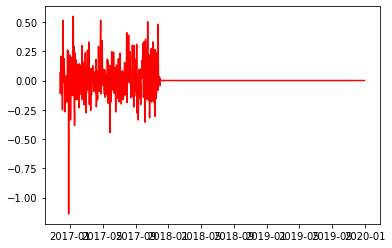

In [377]:
plt.plot(model_fit.predict(start=pd.to_datetime("2016-11-24"),end=pd.to_datetime("2019-12-31"), dynamic=False,typ="levels"),c="r")
#plt.plot(y_test["Energy (kWh)"])
plt.show()

In [75]:
mape = np.mean(np.abs(y_pred.to_numpy() - y_test.values[:n])/np.abs(y_test.values[:n]))
mape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.9926866880739185

In [381]:
n=50
y_pred = model_fit.get_forecast(steps = n).summary_frame()

In [382]:
y_pred

Energy (kWh),mean,mean_se,mean_ci_lower,mean_ci_upper
2017-11-24,0.482140,0.178024,0.133219,0.831061
2017-11-25,-0.027939,0.244881,-0.507896,0.452018
2017-11-26,-0.005464,0.244889,-0.485439,0.474510
2017-11-27,0.012269,0.244891,-0.467708,0.492245
2017-11-28,0.034959,0.244896,-0.445028,0.514946
2017-11-29,-0.021000,0.245040,-0.501270,0.459270
2017-11-30,-0.044527,0.245232,-0.525172,0.436119
2017-12-01,0.020233,0.245614,-0.461162,0.501628
2017-12-02,0.009113,0.245731,-0.472510,0.490736
2017-12-03,0.004150,0.245754,-0.477519,0.485819


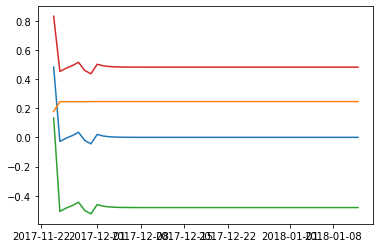

In [383]:
plt.plot(y_pred)
plt.show()

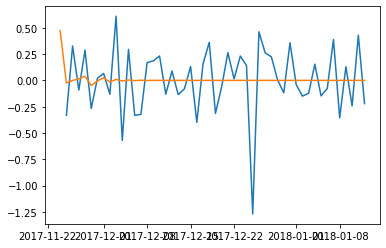

In [353]:
plt.plot(y_test["Energy (kWh)"][:n])
plt.plot(y_pred)
plt.show()